In [1]:
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
 
# spacy for lemmatization
import spacy
 
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
import os
import pandas as pd
import numpy as np
import csv
import re

In [3]:
#读入数据
group_1_del = pd.read_csv('D:\my research\group\group_1\group_1_final.csv',encoding='utf-8')
group_1_del.columns = ['0','content','date','time','user_id','cut_content','del']
group_1_del = group_1_del.drop(columns='0')
group_1_del.head()

,content,date,time,user_id,cut_content,del
0,#上海疫情##上海民生##就这一刻##返乡# 上海返乡潮开启，安徽、江苏和河南人最多，隔离和...,2022-04-24,2022-04-24 08:33:43,1000074972,# 上海 疫情 ## 上海 民生 ## 就 这 一刻 ## 返乡 # 上海 返乡 潮 开...,疫情 民生 一刻 返乡 返乡 潮 开启 安徽 江苏 河南人 隔离 做 核酸 钱 返乡 潮...
1,#上海疫情##上海民生##上海现状# .上海的现状为什么会变成这样我忍不住地继续瞎想外行领导...,2022-04-23,2022-04-23 05:46:14,1000074972,# 上海 疫情 ## 上海 民生 ## 上海 现状 # . 上海 的 现状 为什么 会 ...,疫情 民生 现状 现状 忍不住 瞎 想 外行 领导 内行 内行 闭嘴 同理 衍生 行业 ...
2,#上海疫情##上海民生# 无间道，罗生门，可能本来就是人生如戏吧，是我太认真了。算...,2022-04-22,2022-04-22 11:47:31,1000074972,# 上海 疫情 ## 上海 民生 # 无间道 ， 罗生门 ， 可能 ...,疫情 民生 无间道 罗生门 本来 人生 如戏 是我太 算了 干脆 眼...
3,#上海民生##上海疫情##上海团长# 还是你牛逼呀，团长。开个车照送，还是封控小区。,2022-04-22,2022-04-22 09:41:33,1000074972,# 上海 民生 ## 上海 疫情 ## 上海 团长 # 还是 你 牛 逼 呀 ， 团长 ...,民生 疫情 团长 牛 逼 团长 开个 车照 送 封控 小区
4,明康汇的采购员你成功地把你们老板一个月来的光辉形象給黑了。@明康汇 @市场监管 @江丄孤舟 ...,2022-04-21,2022-04-21 08:54:29,1000074972,明康汇 的 采购员 你 成功 地 把 你们 老板 一个月 来 的 光辉 形象 給黑 了 。 ...,明康汇 采购员 成功 老板 一个月 光辉 形象 給黑 明康汇 市场监管 江 丄 孤 ...


In [4]:
import pyLDAvis.sklearn
import pyLDAvis
import pyLDAvis.gensim

### 指标
c_uci论文：主题一致性的自动评估作者：Newman，Lau，Grieser和Baldwin; 
u_mass论文：在主题模型中优化语义一致性论文作者：Mimno，Wallach，Talley，Leenders和McCallum; 
c_npmi论文：使用分布语义学评估主题连贯性作者：Aletras，Stevenson; 
c_v论文：探索主题连贯性度量的空间作者：R？Der，两者，欣内堡

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.decomposition import LatentDirichletAllocation 
from sklearn.feature_extraction.text import CountVectorizer 
import pyLDAvis.sklearn 
import pyLDAvis 

In [6]:
# 按行删除：存在空值，即删除该行
un = group_1_del.dropna(axis=0, how='any')
un.shape

(284267, 6)

In [7]:
aaa = list(un['del'])
aaa

['疫情 民生 一刻 返乡   返乡 潮 开启 安徽 江苏 河南人 隔离 做 核酸 钱 返乡 潮 开启 滞留 人员 陆续 返乡 安徽 江苏 河南 返乡 人员 ',
 '疫情 民生 现状   现状 忍不住 瞎 想 外行 领导 内行 内行 闭嘴 同理 衍生 行业 一条 汉奸 真的 太 抗战 那会 太 敏感 我乎 审核 说 一条 有人 发国难财 能量 不小 ',
 '疫情 民生             无间道 罗生门 本来 人生 如戏 是我太 算了 干脆 眼一闭 当作 事情 发生 岁月 静好 叫唤 ',
 '民生 疫情 团长   牛 逼 团长 开个 车照 送 封控 小区 ',
 '明康汇 采购员 成功 老板 一个月 光辉 形象 給黑 明康汇   市场监管   江 丄 孤 舟   中国新闻社 ',
 '疫情 民生 物资   黑市     ',
 '民生 疫情   外卖 骑手 好自为之 骑手 代购 袋 泡面  鸡蛋 收取  元 警方 调查 惊人 发现 最新消息 证实 赵某 因涉嫌 非法经营 罪 长宁 警方 依法 强制措施 案件 进一步 侦办 中 ',
 '民生 疫情   连花清 瘟 牛 逼 连花清 瘟 站台  收钱 办事 钱能 挣 一大批 粉丝 数十万 数百万  金  纷纷 连花清 瘟 站台 证实  收钱 连花清 瘟 站台 事实   ',
 '疫情 民生   救护车 谎称 进 小区 救人 买  条烟 业主 震怒 报 次警 近日 救护车 谎称 进 小区 救人 实则 买烟 新闻 引发 关注 ',
 '疫情 民生   跑腿 代购 牛 逼   ',
 '疫情 民生 刚刚 明白   网传 真的 网传 嘉定 静默 天 取消 快递 嘉定区 防控 办 月   日   市 统一 部署   全区 综合 防控 措施   发起 清零 攻坚 网传 嘉定 静默 天 取消 快递 嘉定区 防控 办 月   日   市 统一 部署   全区 综合 防控 措施   发起 清零 攻坚 ',
 '疫情   核酸 检测 强烈建议 专业 事要 专业 人来 做 楼 里  未 拉走 居委会 老先生 老太太 志愿者 包括 毛估估 漏洞百出   ',
 '疫情 民生 有钱人 玩 事关 老百姓 民生 呼吁 政府部门 管管   ',
 '疫情 民生   不算 太贵 老板 还算 良心 关键 至少 送货 只会 送 烂 菜 枯叶 要强 

In [8]:
data_set=[]  #建立存储分词的列表
for i in aaa:
    result=[]
    seg_list = str(i).split()
    for w in seg_list :  #读取每一行分词
        result.append(w)
    data_set.append(result)
print(data_set)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [9]:
# 构造dictionary和corpus 
# dictionary：{序号：单词}比如{0: 你好} 
dictionary = corpora.Dictionary(data_set) 
# corpus ： {序号：单词的频数}比如{0: 3}就是0号单词（你好）出现了3次 
corpus = [dictionary.doc2bow(text) for text in data_set]

In [ ]:
dictionary

In [8]:
# 困惑度的XY坐标
x_perplexity = [] 
y_perplexity = [] 
# 一致性的XY坐标
x_coherence = [] 
y_coherence = [] 

In [9]:
#corpus：就是上边构造的corpus词袋
#num_topics：主题个数，为循环值
#id2word：就是上边构造的dictionary字典
#passes：模型的训练次数
for i in range(1, 30):     
    # 循环生成主题数为i的模型， passes代表模型训练次数，数据量太大了，搞小一点。     
    lda_corpus = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=i, id2word=dictionary, passes=10)     
    # 计算当前模型困惑度
    cur_perplexity = lda_corpus.log_perplexity(corpus)     
    # 构造横纵坐标轴数据
    x_perplexity.append(i)
    y_perplexity.append(cur_perplexity) 
    # 计算一致性
    cv_tmp = gensim.models.CoherenceModel(model=lda_corpus, texts=data_set, dictionary=dictionary, coherence='c_v') 
    x_coherence.append(i) 
    y_coherence.append(cv_tmp.get_coherence()) 
    # 为每个不同的主题渲染可视化模型并存储
    #vis_data = pyLDAvis.gensim.prepare(lda_corpus, corpus, dictionary)
    #pyLDAvis.show(vis_data, open_browser=False)
    #tempHtmlPath = 'D:\my research\group'
    #pyLDAvis.save_html(vis_data, tempHtmlPath + str(i) + '.html') 

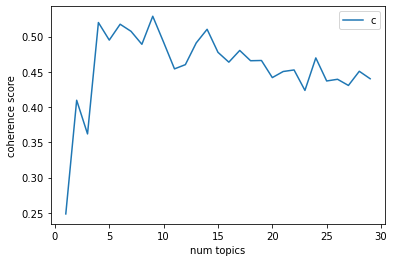

In [16]:
# 绘制一致性折线图 
plt.plot(x_coherence, y_coherence) 
plt.xlabel('num topics') 
plt.ylabel('coherence score') 
plt.legend(('coherence_values'), loc='best') 
plt.savefig('D:\my research\coherenceLine.jpg') 
plt.show() 

In [14]:
cohen = pd.DataFrame(y_coherence, x_coherence)

In [17]:
cohen.to_csv('D:\my research\group\coherence.csv',encoding="utf-8_sig") 

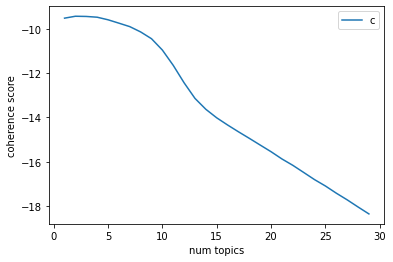

In [19]:
# 绘制困惑度折线图 
plt.plot(x_perplexity, y_perplexity) 
plt.xlabel('num topics') 
plt.ylabel('coherence score') 
plt.legend(('coherence_values'), loc='best') 
plt.savefig('perplexityLine.jpg') 
plt.show()  

In [23]:
prep = pd.DataFrame(y_perplexity, x_perplexity)

In [22]:
prep.to_csv('D:\my research\group\perplexity.csv',encoding="utf-8_sig") 

In [25]:
x=0
for i in corpus:
    if len(i)==0:
        x+=1
print(x)

2199


In [26]:
en_corpus = [x for x in corpus if len(x)>0]

In [29]:
lda_corpus = gensim.models.ldamodel.LdaModel(corpus=en_corpus, num_topics=4, id2word=dictionary, passes=10) 

In [36]:
#vis_data = pyLDAvis.gensim.prepare(lda_corpus, en_corpus, dictionary)
#vis_data = pyLDAvis.gensim.prepare(lda_corpus, en_corpus, dictionary)

In [ ]:
pyLDAvis.show(vis_data, open_browser=TRUE)
tempHtmlPath = 'D:\my research\group\corpusLDA_'
pyLDAvis.save_html(vis_data, tempHtmlPath + str(i) + '.html') 

In [37]:
print(data_set[:1])

[['疫情', '民生', '一刻', '返乡', '返乡', '潮', '开启', '安徽', '江苏', '河南人', '隔离', '做', '核酸', '钱', '返乡', '潮', '开启', '滞留', '人员', '陆续', '返乡', '安徽', '江苏', '河南', '返乡', '人员']]


In [39]:
# Create Dictionary
id2word = corpora.Dictionary(data_set)
# Create Corpus
texts = data_set
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 2), (4, 2), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 5), (14, 1), (15, 1), (16, 1)]]


In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [41]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.068*"疫情" + 0.021*"例" + 0.018*"核酸" + 0.016*"小区" + 0.015*"做" + 0.014*"月" + '
  '0.012*"新增" + 0.012*"确诊" + 0.012*"无症状" + 0.011*"隔离"'),
 (1,
  '0.018*"刘宇宁" + 0.011*"兄弟" + 0.011*"摩登" + 0.009*"喜欢" + 0.009*"哈哈哈" + '
  '0.007*"爱" + 0.006*"世界" + 0.006*"中国" + 0.005*"生活" + 0.005*"希望"'),
 (2,
  '0.020*"说" + 0.020*"真的" + 0.009*"年" + 0.005*"做" + 0.005*"健康" + 0.004*"工作" + '
  '0.004*"事情" + 0.004*"完" + 0.004*"中" + 0.004*"发生"'),
 (3,
  '0.029*"想" + 0.020*"吃" + 0.011*"买" + 0.006*"朋友" + 0.006*"甜" + 0.006*"分享" + '
  '0.006*"东西" + 0.006*"芝士" + 0.005*"⃣" + 0.005*"买菜"')]


In [46]:
# Visualize the topics
#pyLDAvis.enable_notebook()
#vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
#vis

### TF-IDF

In [ ]:
group_1_del['del']

In [53]:
#完善停用词表
new = (['顾魏','特别','越来越','好像','我要','刚刚','天天','林之校','啊啊啊','王一博','翟潇闻','真的','哈哈哈','感觉',
       '不到','一点','呜呜','哈哈哈哈','好好','这是','时代','少年','余生','指教','本来','晚上','天天','不想'])

In [ ]:
def cut(x):
    return [word for word, flag in pseg.cut(x) if flag in ['n','v','a','r','i']]

texts = [cut(a) for a in data]


In [57]:
aaa = []
for line in group_1_del['del']:
    line_u = ' '.join(str(line).split())
    line_uu = line_u.split()#将一个元素按空格拆分成多个元素
    outstr = ''
    for words in line_uu:
        if words not in new:
            #if words in ['n','v','a','r','i']:
                outstr += words
                outstr += " "
    aaa.append(outstr)

In [58]:
aaa

['疫情 民生 一刻 返乡 返乡 潮 开启 安徽 江苏 河南人 隔离 做 核酸 钱 返乡 潮 开启 滞留 人员 陆续 返乡 安徽 江苏 河南 返乡 人员 ',
 '疫情 民生 现状 现状 忍不住 瞎 想 外行 领导 内行 内行 闭嘴 同理 衍生 行业 一条 汉奸 太 抗战 那会 太 敏感 我乎 审核 说 一条 有人 发国难财 能量 不小 ',
 '疫情 民生 无间道 罗生门 人生 如戏 是我太 算了 干脆 眼一闭 当作 事情 发生 岁月 静好 叫唤 ',
 '民生 疫情 团长 牛 逼 团长 开个 车照 送 封控 小区 ',
 '明康汇 采购员 成功 老板 一个月 光辉 形象 給黑 明康汇 市场监管 江 丄 孤 舟 中国新闻社 ',
 '疫情 民生 物资 黑市 ',
 '民生 疫情 外卖 骑手 好自为之 骑手 代购 袋 泡面 鸡蛋 收取 元 警方 调查 惊人 发现 最新消息 证实 赵某 因涉嫌 非法经营 罪 长宁 警方 依法 强制措施 案件 进一步 侦办 中 ',
 '民生 疫情 连花清 瘟 牛 逼 连花清 瘟 站台 收钱 办事 钱能 挣 一大批 粉丝 数十万 数百万 金 纷纷 连花清 瘟 站台 证实 收钱 连花清 瘟 站台 事实 ',
 '疫情 民生 救护车 谎称 进 小区 救人 买 条烟 业主 震怒 报 次警 近日 救护车 谎称 进 小区 救人 实则 买烟 新闻 引发 关注 ',
 '疫情 民生 跑腿 代购 牛 逼 ',
 '疫情 民生 明白 网传 网传 嘉定 静默 天 取消 快递 嘉定区 防控 办 月 日 市 统一 部署 全区 综合 防控 措施 发起 清零 攻坚 网传 嘉定 静默 天 取消 快递 嘉定区 防控 办 月 日 市 统一 部署 全区 综合 防控 措施 发起 清零 攻坚 ',
 '疫情 核酸 检测 强烈建议 专业 事要 专业 人来 做 楼 里 未 拉走 居委会 老先生 老太太 志愿者 包括 毛估估 漏洞百出 ',
 '疫情 民生 有钱人 玩 事关 老百姓 民生 呼吁 政府部门 管管 ',
 '疫情 民生 不算 太贵 老板 还算 良心 关键 至少 送货 只会 送 烂 菜 枯叶 要强 ',
 '疫情 民生 抗疫 物资 话 抓 枪毙 ',
 '疫情 民生 民间 自发 团购 能力 配货 送货 政府 组织 商委 市场 管理局 ',
 '疫情 基层干部 太 当回事 

In [60]:
# 构造 TF-IDF
#tf_idf_vectorizer = TfidfVectorizer()
tf_idf_vectorizer = TfidfVectorizer(min_df = 0.001,max_df = 0.8)
tf_idf = tf_idf_vectorizer.fit_transform(aaa)

In [61]:
# 特征词列表
feature_names = tf_idf_vectorizer.get_feature_names()
# 特征词 TF-IDF 矩阵
matrix = tf_idf.toarray()
feature_names_df = pd.DataFrame(matrix,columns=feature_names)
print(feature_names_df)
feature_names_df

        nan  一下子  一个个  一个多月       一个月   一人   一件   一份   一会  一会儿  ...   高价   高考  \
0       0.0  0.0  0.0   0.0  0.000000  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
1       0.0  0.0  0.0   0.0  0.000000  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2       0.0  0.0  0.0   0.0  0.000000  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
3       0.0  0.0  0.0   0.0  0.000000  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
4       0.0  0.0  0.0   0.0  0.544501  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
...     ...  ...  ...   ...       ...  ...  ...  ...  ...  ...  ...  ...  ...   
284768  0.0  0.0  0.0   0.0  0.000000  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
284769  0.0  0.0  0.0   0.0  0.000000  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
284770  0.0  0.0  0.0   0.0  0.000000  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
284771  0.0  0.0  0.0   0.0  0.000000  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
284772  0.0  0.0  0.0   0.0  0.000000  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

         魔幻   鸡蛋   麻烦   黄瓜 

,nan,一下子,一个个,一个多月,一个月,一人,一件,一份,一会,一会儿,...,高价,高考,魔幻,鸡蛋,麻烦,黄瓜,默默,鼓励,鼻子,龚俊
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.544501,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284768,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
284769,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
284770,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
284771,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
# 指定 lda 主题数
n_topics = 4
# 要输出的每个主题的前 n_top_words 个主题词数
n_top_words = 20

lda = LatentDirichletAllocation(
    n_components=n_topics, max_iter=50,
    learning_method='online',
    learning_offset=50.,
    random_state=0)
# 核心，给 LDA 喂生成的 TF-IDF 矩阵
lda.fit(tf_idf)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=50, n_components=4, random_state=0)

In [47]:
def top_words_data_frame(model: LatentDirichletAllocation,
                         tf_idf_vectorizer: TfidfVectorizer,
                         n_top_words: int) -> pd.DataFrame:
    '''
    求出每个主题的前 n_top_words 个词

    Parameters
    ----------
    model : sklearn 的 LatentDirichletAllocation 
    tf_idf_vectorizer : sklearn 的 TfidfVectorizer
    n_top_words :前 n_top_words 个主题词

    Return
    ------
    DataFrame: 包含主题词分布情况
    '''
    rows = []
    feature_names = tf_idf_vectorizer.get_feature_names()
    for topic in model.components_:
        top_words = [feature_names[i]
                     for i in topic.argsort()[:-n_top_words - 1:-1]]
        rows.append(top_words)
    columns = [f'topic {i+1}' for i in range(n_top_words)]
    df = pd.DataFrame(rows, columns=columns)

    return df


def predict_to_data_frame(model: LatentDirichletAllocation, X: np.ndarray) -> pd.DataFrame:
    '''
    求出文档主题概率分布情况

    Parameters
    ----------
    model : sklearn 的 LatentDirichletAllocation 
    X : 词向量矩阵

    Return
    ------
    DataFrame: 包含主题词分布情况
    '''
    # 求出给定文档的主题概率分布矩阵
    matrix = model.transform(X)
    columns = [f'P(topic {i+1})' for i in range(len(model.components_))]
    df = pd.DataFrame(matrix, columns=columns)
    return df

In [63]:
# 计算 n_top_words 个主题词
top_words_df = top_words_data_frame(lda, tf_idf_vectorizer, n_top_words)
top_words_df
# 保存 n_top_words 个主题词到 csv 文件中
#top_words_df.to_csv(top_words_csv_path, encoding='utf-8-sig', index=None)

# 转 tf_idf 为数组，以便后面使用它来对文本主题概率分布进行计算
X = tf_idf.toarray()

# 计算完毕主题概率分布情况
predict_df = predict_to_data_frame(lda, X)
predict_df
# 保存文本主题概率分布到 csv 文件中
#predict_df.to_csv(predict_topic_csv_path, encoding='utf-8-sig', index=None)

,P(topic 1),P(topic 2),P(topic 3),P(topic 4)
0,0.067086,0.734563,0.065881,0.132470
1,0.066934,0.067369,0.067531,0.798166
2,0.070303,0.070597,0.459870,0.399230
3,0.085649,0.282014,0.394327,0.238010
4,0.091617,0.291160,0.320889,0.296335
...,...,...,...,...
284768,0.122306,0.091688,0.104743,0.681262
284769,0.292854,0.087156,0.228382,0.391608
284770,0.067384,0.182755,0.086907,0.662954
284771,0.049256,0.284527,0.131173,0.535044


In [ ]:
pyLDAvis.enable_notebook()
data = pyLDAvis.sklearn.prepare(lda, tf_idf, tf_idf_vectorizer)
#让可视化可以在notebook内显示
pyLDAvis.show(data)

D:\Program_Files\anaconda\lib\site-packages\pyLDAvis\_prepare.py:228: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info  = pd.DataFrame({'saliency': saliency, 'Term': vocab, \



Note: if you're in the IPython notebook, pyLDAvis.show() is not the best command
      to use. Consider using pyLDAvis.display(), or pyLDAvis.enable_notebook().
      See more information at http://pyLDAvis.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8889/    [Ctrl-C to exit]


127.0.0.1 - - [20/Oct/2022 16:11:47] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [20/Oct/2022 16:11:48] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [20/Oct/2022 16:13:23] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [20/Oct/2022 16:13:23] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [20/Oct/2022 16:13:23] "GET /LDAvis.js HTTP/1.1" 200 -


In [ ]:
cv_tmp = gensim.models.CoherenceModel(model=lda, texts=data_set, dictionary=dictionary, coherence='c_v') 
x_coherence.append(i) 
    y_coherence.append(cv_tmp.get_coherence()) 

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, ti, id2word)
vis